In [1]:
import bz2
import os
import re
import pickle
import sys
from glob import glob
import pandas as pd
import numpy as np
import plotnine as p9
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3

In [2]:
def mean_abundance_occurrence(row, columns):
    mean_abun = 0
    total_abun = 0
    mean_occu = 0
    total_occu = 0
    
    for i in columns:
        total_abun += float(row[i])
        if float(row[i]) > 1e-6:
            total_occu += 1
    
    mean_abun = total_abun / len(columns)
    mean_occu = total_occu / len(columns)
    
    return pd.Series([total_abun, total_occu, mean_abun, mean_occu], index=["total_abun", "total_occu", "mean_abun", "mean_occu"])


def composition_all_raito(row):
    raito = 0
    if row["kmgs_cluster_count"] > 0:
        raito = row["kmgs_all_sgb_count"] / row["kmgs_cluster_count"]
    if row["umgs_cluster_count"] > 0:
        raito += row["umgs_all_sgb_count"] / row["umgs_cluster_count"]
    return raito

def composition_oral_raito(row):
    raito = 0
    if row["kmgs_cluster_count"] > 0:
        raito = row["kmgs_oral_sgb_count"] / row["kmgs_cluster_count"]
    if row["umgs_cluster_count"] > 0:
        raito += row["umgs_oral_sgb_count"] / row["umgs_cluster_count"]
    return raito

def mag_prop(row):
    return row["mgs_mag_count"] / (row["reference_genome_count"] + 1)

def reference_genome_number(row):
    #return row["oral_genome"] - row["MAG"]
    return row["size"] - row["MAG"]

def composition(row):
    return row["MAG"] / (row["reference_genome_num"] + 1)

In [3]:
mgs_info = pd.read_csv("/hwfssz1/ST_META/P18Z10200N0127_MA/zhujie/igo/assay/taxonomy/lineages_gtdb/oral_mgs_gtdb_taxonomy.tsv", sep='\t')

genus_size = mgs_info.groupby("lineages_genus_new")\
                     .size()\
                     .reset_index()\
                     .rename(columns={0: "count"})\
                     .sort_values("count", ascending=False)

genus_size_info = mgs_info.merge(genus_size)\
                          .loc[:, ["mgs_id", "mtype", "mgs_id_old", 
                                   "size", "MAG", "oral_genome", 
                                   "lineages_genus_new", "count"]]\
                          .set_index("lineages_genus_new", drop=False)


genus_size_all = pd.DataFrame(
    columns=["lineages_genus_new", "kmgs_all_sgb_count", "umgs_all_sgb_count", "mgs_all_sgb_count", 
             "kmgs_oral_sgb_count", "umgs_oral_sgb_count", "mgs_oral_sgb_count",
             "kmgs_cluster_count", "umgs_cluster_count", "mgs_cluster_count",                      
             "kmgs_mag_count", "umgs_mag_count", "mgs_mag_count", "reference_genome_count"])                          
                                       
for i in genus_size_info.index.unique():
    kmgs_cluster_count, umgs_cluster_count, mgs_cluster_count = 0, 0, 0
    kmgs_all_sgb_count, umgs_all_sgb_count, mgs_all_sgb_count = 0, 0, 0
    kmgs_oral_sgb_count, umgs_oral_sgb_count, mgs_oral_sgb_count = 0, 0, 0
    kmgs_mag_count, umgs_mag_count, mgs_mag_count = 0, 0, 0
    
    if isinstance(genus_size_info.loc[i, ["mtype"]], pd.core.frame.DataFrame):
        kmgs_cluster_count = len(genus_size_info.loc[i, ["mtype"]]\
                                                .query('mtype == "kMGS"'))
        umgs_cluster_count = len(genus_size_info.loc[i, ["mtype"]]\
                                                .query('mtype == "uMGS"'))

        kmgs_all_sgb_count = int(sum(genus_size_info.loc[i, ["mtype", "size"]]\
                                                    .query('mtype == "kMGS"')["size"]))
        umgs_all_sgb_count = int(sum(genus_size_info.loc[i, ["mtype", "size"]]\
                                                    .query('mtype == "uMGS"')["size"]))
        
        kmgs_mag_count = int(sum(genus_size_info.loc[i, ["mtype", "MAG"]]\
                                                .query('mtype == "kMGS"')["MAG"]))
        umgs_mag_count = int(sum(genus_size_info.loc[i, ["mtype", "MAG"]]\
                                                .query('mtype == "uMGS"')["MAG"]))

        kmgs_oral_sgb_count = int(sum(genus_size_info.loc[i, ["mtype", "oral_genome"]]\
                                                     .query('mtype == "kMGS"')["oral_genome"]))
        umgs_oral_sgb_count = int(sum(genus_size_info.loc[i, ["mtype", "oral_genome"]]\
                                                     .query('mtype == "uMGS"')["oral_genome"]))
    else:
        count_dict = genus_size_info.loc[i].to_dict()
        if count_dict["mtype"] == "uMGS":
            umgs_cluster_count = int(count_dict["count"])
            umgs_all_sgb_count = int(count_dict["size"])
            umgs_mag_count = int(count_dict["MAG"])
            umgs_oral_sgb_count = int(count_dict["oral_genome"])
        else:
            kmgs_cluster_count = int(count_dict["count"])
            kmgs_all_sgb_count = int(count_dict["size"])
            kmgs_mag_count = int(count_dict["MAG"])
            kmgs_oral_sgb_count = int(count_dict["oral_genome"])

    mgs_cluster_count = kmgs_cluster_count + umgs_cluster_count
    mgs_oral_sgb_count = kmgs_oral_sgb_count + umgs_oral_sgb_count
    
    mgs_all_sgb_count = kmgs_all_sgb_count + umgs_all_sgb_count
    
    mgs_mag_count = kmgs_mag_count + umgs_mag_count
    reference_genome_count = mgs_all_sgb_count - mgs_mag_count
    #if reference_genome_count <= 0:
    #   print(i)

    genus_size_all = genus_size_all.append({
        "lineages_genus_new": i,
        "umgs_all_sgb_count": umgs_all_sgb_count,
        "kmgs_all_sgb_count": kmgs_all_sgb_count,
        "mgs_all_sgb_count": mgs_all_sgb_count,
        "umgs_oral_sgb_count": umgs_oral_sgb_count,
        "kmgs_oral_sgb_count": kmgs_oral_sgb_count,
        "mgs_oral_sgb_count": mgs_oral_sgb_count,
        "umgs_cluster_count": umgs_cluster_count,
        "kmgs_cluster_count": kmgs_cluster_count,
        "mgs_cluster_count": mgs_cluster_count,
        "umgs_mag_count": umgs_mag_count,
        "kmgs_mag_count": kmgs_mag_count,
        "mgs_mag_count": mgs_mag_count,
        "reference_genome_count": reference_genome_count
    }, ignore_index=True)

In [4]:
def get_ten_genus(genus_profile_, strain_profile_, genus_size_all):
    genus_profile = pd.read_csv(genus_profile_, sep='\t')
    samples_list = genus_profile.columns[1:].to_list()

    genus_profile_2 = genus_profile
    genus_profile_2[["total_abun", "total_occu", "mean_abun", "mean_occu"]] = genus_profile_2.apply(lambda x: mean_abundance_occurrence(x, samples_list), axis=1)
    genus_profile_2 = genus_profile_2.loc[:, ["lineages_genus_new", "total_abun", "total_occu", "mean_abun", "mean_occu"]]

    genus_info = genus_profile_2.merge(genus_size_all)

    genus_info["composition_all_raito"] = genus_info.apply(composition_all_raito, axis=1)
    genus_info["composition_oral_raito"] = genus_info.apply(composition_oral_raito, axis=1)
    genus_info["mag_prop"] = genus_info.apply(mag_prop, axis=1)
    
    genus_info["rank"] = genus_info[["mean_abun", "mean_occu", "composition_all_raito"]]\
                            .apply(tuple, axis=1)\
                            .rank(method='average', ascending=False).astype(int)

    top_ten_genus = genus_info.sort_values("rank")\
                              .loc[:, ["rank", "lineages_genus_new", "mean_abun", "mean_occu", "composition_all_raito"]]\
                              .head(10).lineages_genus_new.values

    for i in top_ten_genus:
        genus = i.split("|")[-1]
        os.makedirs(os.path.join("top_genus", genus), exist_ok=True)

    strain_profile = pd.read_csv(strain_profile_, sep='\t')
    strain_profile["lineages_genus_new"] = strain_profile.lineages_strain_new.apply(lambda x: x.split("|s__")[0])

    top_ten_genus_profile = strain_profile.set_index("lineages_genus_new")\
                                          .loc[top_ten_genus, ]\
                                          .reset_index()

    top_ten_genus_profile[["total_abun", "total_occu", "mean_abun", "mean_occu"]] = \
        top_ten_genus_profile.apply(lambda x: mean_abundance_occurrence(x, samples_list), axis=1)
    top_ten_genus_profile = top_ten_genus_profile.loc[:, ["lineages_strain_new", "lineages_genus_new", "total_abun", "total_occu", "mean_abun", "mean_occu"]]

    top_ten_genus_info = top_ten_genus_profile.merge(mgs_info).set_index("lineages_genus_new")

    top_ten_genus_dict = {}
    for i in top_ten_genus:
        genus = i.split("|")[-1]
        top_ten_genus_dict[genus] = top_ten_genus_info.loc[i, ].reset_index()
        top_ten_genus_dict[genus]["reference_genome_num"] = top_ten_genus_dict[genus].apply(reference_genome_number, axis=1)
        top_ten_genus_dict[genus]["composition_raito"] = top_ten_genus_dict[genus].apply(composition, axis=1)
        top_ten_genus_dict[genus]["rank"] = top_ten_genus_dict[genus][["mean_abun", "total_occu", "composition_raito"]]\
                                                .apply(tuple, axis=1)\
                                                .rank(method='average', ascending=False).astype(int)
    return top_ten_genus_dict

In [5]:
top_ten_genus = get_ten_genus("../profilling/profile_merged/abundance_profile_genus.tsv",
                              "../profilling/profile_merged/abundance_profile_strain.tsv",
                              genus_size_all)
top_ten_genus_jgi = get_ten_genus("../profilling/profile_merged/abundance_profile_genus.jgi.tsv",
                                  "../profilling/profile_merged/abundance_profile_strain.jgi.tsv",
                                  genus_size_all)

In [6]:
columns = ['rank', 'mgs_id', 'lineages_genus_new', 'lineages_strain_new',
           'mean_abun', 'mean_occu',  'size', 'mtype', 'representative',
           'MAG', 'oral_genome', 'rep_path', 'genome_lst', 'reference_genome_num', 'composition_raito']

In [7]:
def choose_ten_speceis(row):
    def mag_prob(row):
        return row["MAG"] / row["size"]
    def mag_prob_is(row):
        if row["MAG"] / row["size"] > 0.5:
            return 1
        else:
            return 0
    def mag_is(row):
        if row["MAG"] > 20:
            return 1
        else:
            return 0
    return pd.Series([mag_prob(row), mag_prob_is(row), mag_is(row)], index=["mag_prob", "mag_prob_is", "mag_is"])

In [8]:
##

In [9]:
all_fna_path = pd.read_csv("/hwfssz1/ST_META/P18Z10200N0127_MA/database/01.distance/fna_list/all_fna_v2.tsv",
                           sep='\t')\
                 .set_index("id", drop=False)

In [10]:
all_fna_path.head()

,fna_path,id
id,,
ERR2764996.14,/hwfssz1/ST_META/P18Z10200N0127_MA/zhujie/pub_...,ERR2764996.14
SRR6748133.8,/hwfssz1/ST_META/P18Z10200N0127_MA/zhujie/pub_...,SRR6748133.8
SRR6748185.1,/hwfssz1/ST_META/P18Z10200N0127_MA/zhujie/pub_...,SRR6748185.1
SRR8114071.7,/hwfssz1/ST_META/P18Z10200N0127_MA/zhujie/pub_...,SRR8114071.7
ERR2764930.9,/hwfssz1/ST_META/P18Z10200N0127_MA/zhujie/pub_...,ERR2764930.9


In [11]:
def get_profile_plot(genus_name):
    profile_genus = top_ten_genus[genus_name].sort_values("rank").query('mtype == "kMGS"').head(10).loc[:, columns]
    profile_plot = profile_genus.loc[:, ["mgs_id", "mean_abun", "mean_occu", "reference_genome_num", "MAG", "lineages_genus_new", "lineages_strain_new"]]

    profile_plot_l = profile_plot\
        .loc[:, ["mgs_id", "mean_abun", "mean_occu", "reference_genome_num", "MAG", "lineages_genus_new", "lineages_strain_new"]] \
        .rename(columns={"reference_genome_num": "Reference genomes",
                     "MAG": "Reconstructed genomes"})\
        .reset_index()\
        .melt(id_vars=['lineages_strain_new', "lineages_genus_new"],
              value_vars=["mean_abun",
                          "mean_occu",
                          "Reference genomes",
                          "Reconstructed genomes"])
    profile_plot_l["genus"] = genus_name.split('__')[-1]
    profile_plot_l["species"] = profile_plot_l.apply(lambda x: x["lineages_strain_new"].split("|")[6], axis=1)
    
    profile_plot["genus"] = genus_name.split('__')[-1]
    profile_plot["species"] = profile_plot.apply(lambda x: x["lineages_strain_new"].split("|")[6], axis=1)
    return profile_plot, profile_plot_l

In [12]:
genus = set()
genus.update(set(top_ten_genus.keys()))
genus.update(set(top_ten_genus_jgi.keys()))
genus

{'g__Acinetobacter',
 'g__Actinomyces',
 'g__F0040',
 'g__Fusobacterium',
 'g__Haemophilus_D',
 'g__Neisseria',
 'g__Pauljensenia',
 'g__Porphyromonas',
 'g__Prevotella',
 'g__Rothia',
 'g__Streptococcus',
 'g__Veillonella'}

In [13]:
profile_plot_Acinetobacter, profile_plot_l_Acinetobacter = get_profile_plot("g__Acinetobacter")
profile_plot_Actinomyces, profile_plot_l_Actinomyces = get_profile_plot("g__Actinomyces")
#profile_plot_F0040, profile_plot_l_F0040 = get_profile_plot("g__F0040")
profile_plot_Fusobacterium, profile_plot_l_Fusobacterium = get_profile_plot("g__Fusobacterium")
profile_plot_Haemophilus_D, profile_plot_l_Haemophilus_D = get_profile_plot("g__Haemophilus_D")
profile_plot_Neisseria, profile_plot_l_Neisseria = get_profile_plot("g__Neisseria")
profile_plot_Pauljensenia, profile_plot_l_Pauljensenia = get_profile_plot("g__Pauljensenia")
profile_plot_Porphyromonas, profile_plot_l_Porphyromonas = get_profile_plot("g__Porphyromonas")
profile_plot_Prevotella, profile_plot_l_Prevotella = get_profile_plot("g__Prevotella")
#profile_plot_Rothia, profile_plot_l_Rothia = get_profile_plot("g__Rothia")
profile_plot_Streptococcus, profile_plot_l_Streptococcus = get_profile_plot("g__Streptococcus")
profile_plot_Veillonella, profile_plot_l_Veillonella = get_profile_plot("g__Veillonella")

In [14]:
profile_plot_l = pd.concat([profile_plot_l_Acinetobacter,
                            profile_plot_l_Actinomyces,
                            #profile_plot_l_F0040,
                            profile_plot_l_Fusobacterium,
                            profile_plot_l_Haemophilus_D,
                            profile_plot_l_Neisseria,
                            profile_plot_l_Pauljensenia,
                            profile_plot_l_Porphyromonas,
                            profile_plot_l_Prevotella,
                            #profile_plot_l_Rothia,
                            profile_plot_l_Streptococcus,
                            profile_plot_l_Veillonella])
profile_plot = pd.concat([profile_plot_Acinetobacter,
                          profile_plot_Actinomyces,
                          #profile_plot_F0040,
                          profile_plot_Fusobacterium,
                          profile_plot_Haemophilus_D,
                          profile_plot_Neisseria,
                          profile_plot_Pauljensenia,
                          profile_plot_Porphyromonas,
                          profile_plot_Prevotella,
                          #profile_plot_Rothia,
                          profile_plot_Streptococcus,
                          profile_plot_Veillonella])

In [15]:
profile_plot_l.head()

,lineages_strain_new,lineages_genus_new,variable,value,genus,species
0,k__Bacteria|p__Proteobacteria|c__Gammaproteoba...,k__Bacteria|p__Proteobacteria|c__Gammaproteoba...,mean_abun,4.032453e-02,Acinetobacter,s__Acinetobacter idrijaensis_mgs_206
1,k__Bacteria|p__Proteobacteria|c__Gammaproteoba...,k__Bacteria|p__Proteobacteria|c__Gammaproteoba...,mean_abun,8.230069e-05,Acinetobacter,s__Acinetobacter pittii_mgs_3168
2,k__Bacteria|p__Proteobacteria|c__Gammaproteoba...,k__Bacteria|p__Proteobacteria|c__Gammaproteoba...,mean_abun,4.696319e-05,Acinetobacter,s__Acinetobacter baumannii_mgs_13
3,k__Bacteria|p__Proteobacteria|c__Gammaproteoba...,k__Bacteria|p__Proteobacteria|c__Gammaproteoba...,mean_abun,1.657225e-06,Acinetobacter,s__Acinetobacter radioresistens_mgs_280
4,k__Bacteria|p__Proteobacteria|c__Gammaproteoba...,k__Bacteria|p__Proteobacteria|c__Gammaproteoba...,mean_abun,4.963980e-07,Acinetobacter,s__Acinetobacter junii_mgs_150


In [16]:
profile_plot.head()

,mgs_id,mean_abun,mean_occu,reference_genome_num,MAG,lineages_genus_new,lineages_strain_new,genus,species
1,mgs_206,4.032453e-02,0.979759,23,0,k__Bacteria|p__Proteobacteria|c__Gammaproteoba...,k__Bacteria|p__Proteobacteria|c__Gammaproteoba...,Acinetobacter,s__Acinetobacter idrijaensis_mgs_206
4,mgs_3168,8.230069e-05,0.110361,239,4,k__Bacteria|p__Proteobacteria|c__Gammaproteoba...,k__Bacteria|p__Proteobacteria|c__Gammaproteoba...,Acinetobacter,s__Acinetobacter pittii_mgs_3168
0,mgs_13,4.696319e-05,0.253253,3482,0,k__Bacteria|p__Proteobacteria|c__Gammaproteoba...,k__Bacteria|p__Proteobacteria|c__Gammaproteoba...,Acinetobacter,s__Acinetobacter baumannii_mgs_13
5,mgs_280,1.657225e-06,0.058795,26,0,k__Bacteria|p__Proteobacteria|c__Gammaproteoba...,k__Bacteria|p__Proteobacteria|c__Gammaproteoba...,Acinetobacter,s__Acinetobacter radioresistens_mgs_280
3,mgs_150,4.963980e-07,0.080723,28,0,k__Bacteria|p__Proteobacteria|c__Gammaproteoba...,k__Bacteria|p__Proteobacteria|c__Gammaproteoba...,Acinetobacter,s__Acinetobacter junii_mgs_150


/ldfssz1/ST_META/share/User/zhujie/.conda/envs/bioenv/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/ldfssz1/ST_META/share/User/zhujie/.conda/envs/bioenv/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


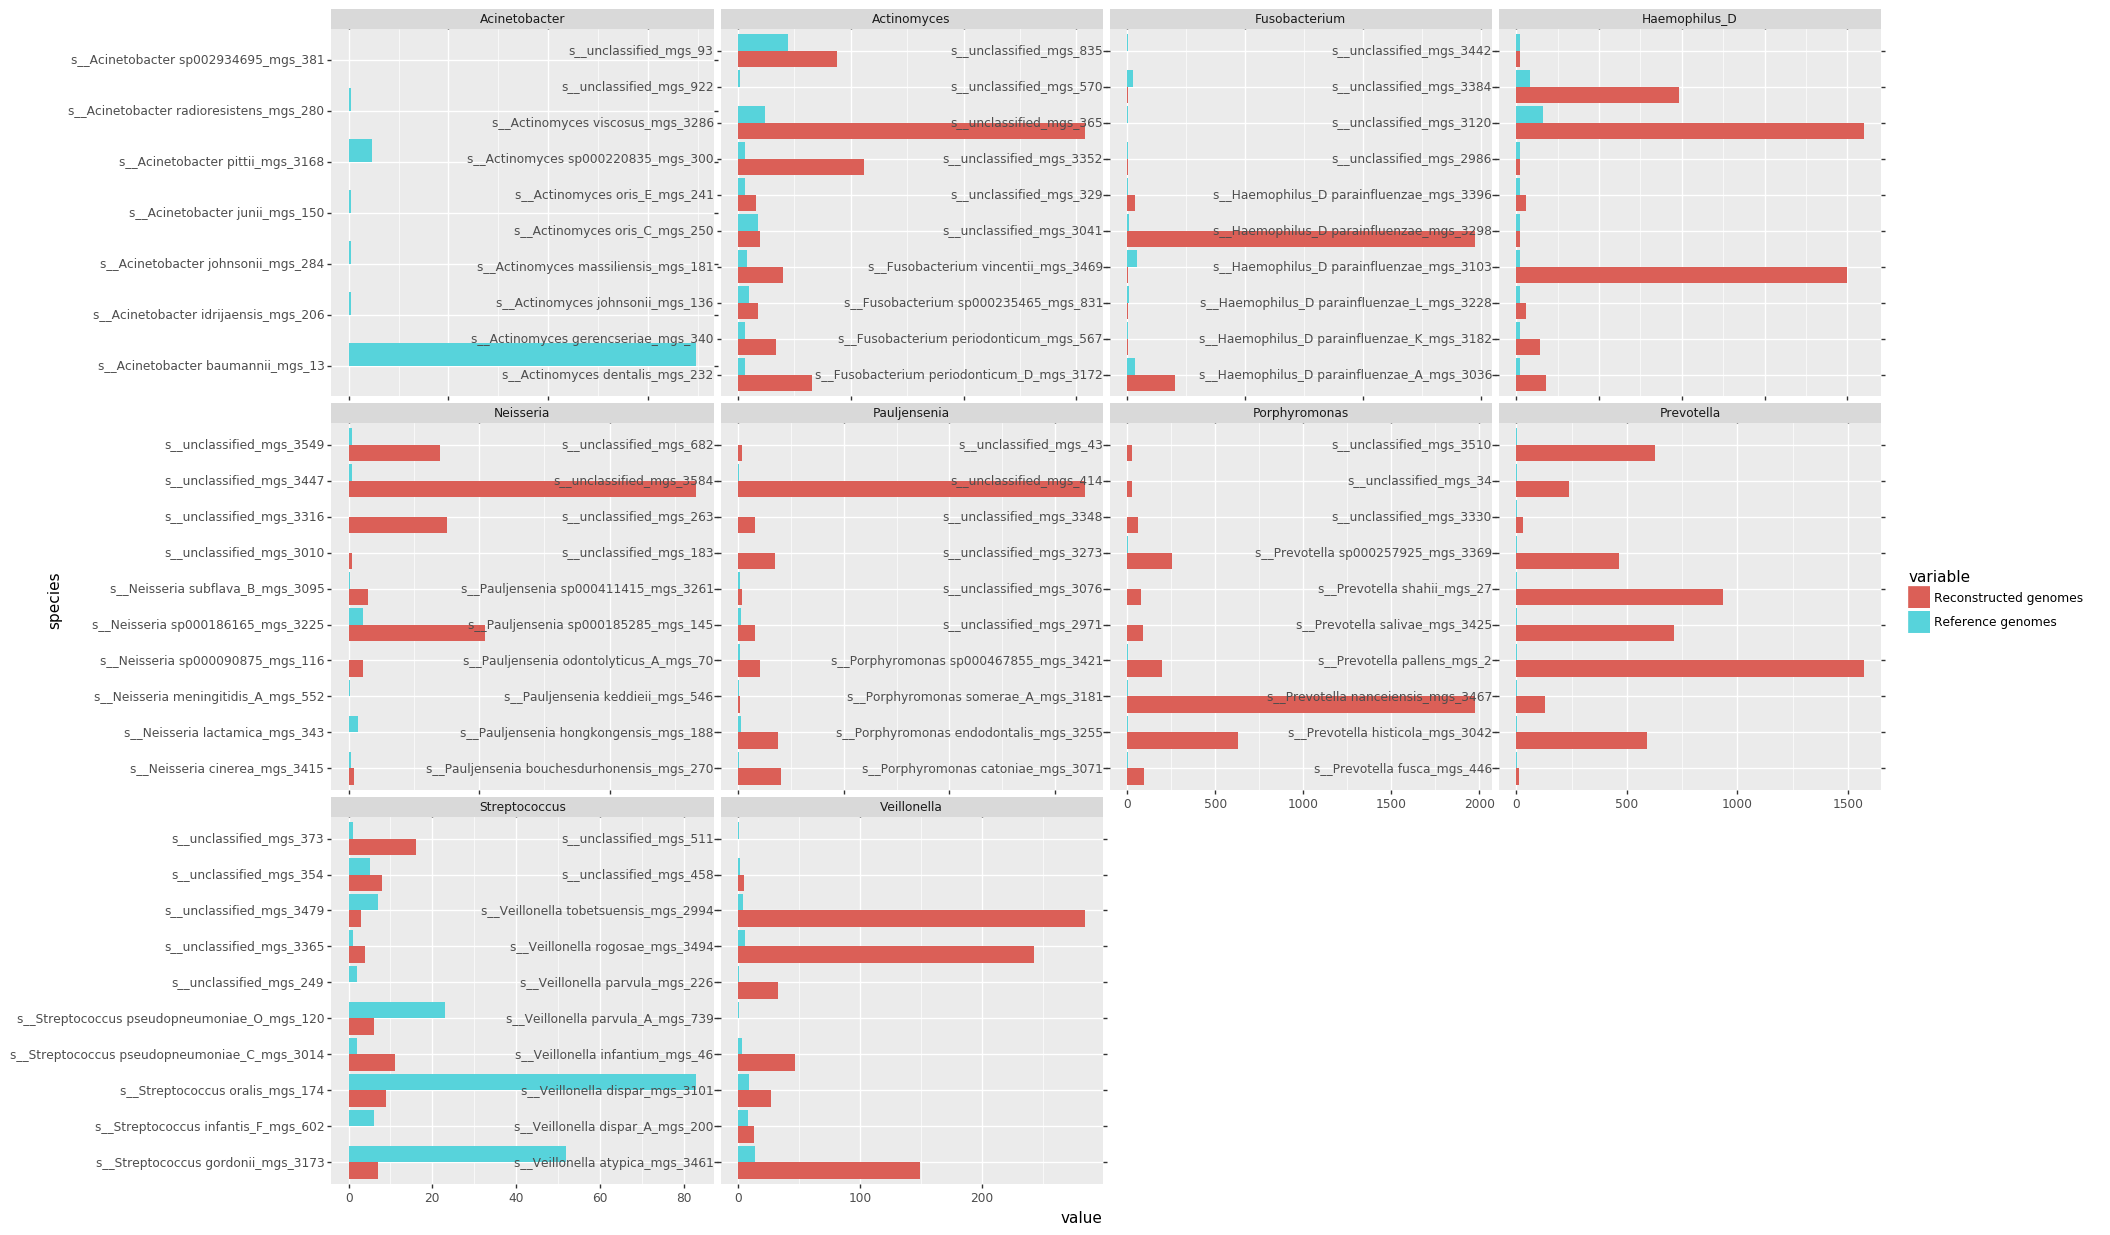

<ggplot: (8773758036751)>

In [17]:
p9.options.figure_size = (20, 15)
(p9.ggplot(profile_plot_l.query('variable == "Reconstructed genomes" or variable == "Reference genomes"'),
           p9.aes(x='species', y='value', fill='variable'))
 + p9.geom_bar(stat='identity', position='dodge')
 + p9.coord_flip()
 + p9.facet_wrap('~genus', scales='free'))

In [19]:
#profile_plot_l.to_csv("metadata/profile_plot_l.tsv", sep='\t', index=False)
#profile_plot.to_csv("metadata/profile_plot.tsv", sep='\t', index=False)

In [20]:
##

In [21]:
genus_keys = ['g__Prevotella', 'g__Neisseria', 'g__Streptococcus', 'g__Veillonella', 'g__Porphyromonas', 'g__Fusobacterium',
              'g__Acinetobacter', 'g__Actinomyces', 'g__Pauljensenia', 'g__Haemophilus_D','g__Rothia', 'g__F0040']

genus_ten_species = {}
genus_ten_species_profile = pd.DataFrame(columns=columns)

for i in genus_keys:
    genus_ten_species[i] = {}
    if i in top_ten_genus:
        genus_ten_species_profile = pd.concat([genus_ten_species_profile, top_ten_genus[i].sort_values("rank").query('mtype == "kMGS"').head(10).loc[:, columns]])
    else:
        genus_ten_species_profile = pd.concat([genus_ten_species_profile, top_ten_genus_jgi[i].sort_values("rank").query('mtype == "kMGS"').head(10).loc[:, columns]])
len(genus_ten_species_profile)

115

In [22]:
genus_ten_species_profile = genus_ten_species_profile.set_index("lineages_genus_new", drop=False)
genus_ten_species_profile2 = genus_ten_species_profile.set_index("mgs_id", drop=False)

In [23]:
genus_ten_species_profile.head()

,rank,mgs_id,lineages_genus_new,lineages_strain_new,mean_abun,mean_occu,size,mtype,representative,MAG,oral_genome,rep_path,genome_lst,reference_genome_num,composition_raito
lineages_genus_new,,,,,,,,,,,,,,,
k__Bacteria|p__Bacteroidota|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Prevotella,1,mgs_3425,k__Bacteria|p__Bacteroidota|c__Bacteroidia|o__...,k__Bacteria|p__Bacteroidota|c__Bacteroidia|o__...,0.010150,1.000000,716,kMGS,YS000166_saliva.19,712,715,/hwfssz1/ST_META/P18Z10200N0127_MA/zhujie/yunn...,"RSZYD18078692_A_saliva.1,RDPYD18189844_A_saliv...",4,142.400000
k__Bacteria|p__Bacteroidota|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Prevotella,2,mgs_27,k__Bacteria|p__Bacteroidota|c__Bacteroidia|o__...,k__Bacteria|p__Bacteroidota|c__Bacteroidia|o__...,0.009094,0.997108,939,kMGS,RSZYD18187792_A_saliva.6,936,937,/hwfssz5/ST_META/P18Z10200N0127_MA/zhujie/sgb_...,"RDPYD18088891_A_togue.40,SEQF2687,RSZYD1807845...",3,234.000000
k__Bacteria|p__Bacteroidota|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Prevotella,3,mgs_3042,k__Bacteria|p__Bacteroidota|c__Bacteroidia|o__...,k__Bacteria|p__Bacteroidota|c__Bacteroidia|o__...,0.008204,0.998795,597,kMGS,RSZYD18187665_A_saliva.4,592,595,/hwfssz5/ST_META/P18Z10200N0127_MA/zhujie/sgb_...,"RSZYD18078304_A_saliva.38,RDPYD18300016_A_sali...",5,98.666667
k__Bacteria|p__Bacteroidota|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Prevotella,4,mgs_2,k__Bacteria|p__Bacteroidota|c__Bacteroidia|o__...,k__Bacteria|p__Bacteroidota|c__Bacteroidia|o__...,0.007192,0.999518,1576,kMGS,YS000214_saliva.17,1572,1574,/hwfssz1/ST_META/P18Z10200N0127_MA/zhujie/yunn...,"RSZAXPI002486-19_RAH_saliva.49,RDPYD18300072_A...",4,314.400000
k__Bacteria|p__Bacteroidota|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Prevotella,7,mgs_34,k__Bacteria|p__Bacteroidota|c__Bacteroidia|o__...,k__Bacteria|p__Bacteroidota|c__Bacteroidia|o__...,0.004282,0.998313,238,kMGS,RSZYD18187206_A_saliva.4,237,238,/hwfssz5/ST_META/P18Z10200N0127_MA/zhujie/sgb_...,"RDPYD18088977_A_saliva.49,RDPYD18189933_A_sali...",1,118.500000


In [24]:
genus_ten_species_profile.index.unique()

Index(['k__Bacteria|p__Bacteroidota|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Prevotella',
       'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Burkholderiales|f__Neisseriaceae|g__Neisseria',
       'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus',
       'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Veillonellales|f__Veillonellaceae|g__Veillonella',
       'k__Bacteria|p__Bacteroidota|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Porphyromonas',
       'k__Bacteria|p__Fusobacteriota|c__Fusobacteriia|o__Fusobacteriales|f__Fusobacteriaceae|g__Fusobacterium',
       'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter',
       'k__Bacteria|p__Actinobacteriota|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces',
       'k__Bacteria|p__Actinobacteriota|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Pauljensenia',
       'k__

In [25]:
links_sh = open("link.sh", 'w')
links_gf_sh = open("link_gff_fna.sh", 'w')

panphlan_sh = open("panphlan_gendb.sh", 'w')
roary_sh = open("roary.sh", 'w')

panphlan_convert_sh = open("panphlan_convert.sh", 'w')
panphlan_convert_ref_sh = open("panphlan_convert_ref.sh", 'w')

rare_sh = open("rarefaction.sh", 'w')
rare_ref_sh = open("rarefaction_ref.sh", 'w')

rare_merge_sh = open("rarefaction_merge.sh", 'w')
rare_merge_ref_sh = open("rarefaction_merge_ref.sh", 'w')

new_list = []
for genu_ in genus_ten_species_profile.index.unique():
    genu = genu_.split("|")[-1]
    for mgs_id in genus_ten_species_profile.loc[genu_, "mgs_id"]:
        dir_    = "top_genus/" + genu + "/fna/" + mgs_id
        gff_dir = "top_genus/" + genu + "/gff/" + mgs_id
        fna_dir = "top_genus/" + genu + "/genomic_fna/" + mgs_id
        pan_dir = "top_genus/" + genu + "/pandb/" + mgs_id
        pan_tmp_dir = mgs_id  + ".pandb.tmp"
        pan_log_file = "logs/" + mgs_id + ".pandb.log"
        roary_dir = "top_genus/" + genu + "/roary/" + mgs_id
        roary_log_file = "logs/" + mgs_id + ".roary.log"
        
        rare_dir = "top_genus/" + genu + "/rarefaction/" + mgs_id
        
        #panphlan_gendb_cmd = "panphlan_pangenome_generation.py -c %s --i_fna %s/ --i_gff %s/ -o %s/ --tmp %s --verbose >%s 2>&1 \n" % (j, fna_dir, gff_dir, pan_dir, pan_tmp_dir, pan_log_file)
        panphlan_gendb_cmd = "mkdir -p %s && cd %s && panphlan_pangenome_generation.py -c %s --i_fna ../../../../%s/ --i_gff ../../../../%s/ -o ./ --tmp ../%s --verbose > ../%s 2>&1 \n" \
        % (pan_dir, pan_dir, mgs_id, fna_dir, gff_dir, pan_tmp_dir, pan_log_file)
        panphlan_sh.write(panphlan_gendb_cmd)
        
        pangenome_csv = os.path.join(pan_dir, "panphlan_" + mgs_id.replace("_", "-") + "_pangenome.csv")
        
        panphlan_convert_cmd = "python scripts/species_profile_from_pangenome.py %s %s\n" % (pangenome_csv, pangenome_csv.replace("pangenome.csv", "strainprof.tsv"))
        panphlan_convert_sh.write(panphlan_convert_cmd)
        
        panphlan_convert_cmd_ref = "python scripts/species_profile_from_pangenome_ref.py %s %s\n" % (pangenome_csv, pangenome_csv.replace("pangenome.csv", "strainprof_ref.tsv"))
        panphlan_convert_ref_sh.write(panphlan_convert_cmd_ref)
        
        roary_cmd = "mkdir -p %s && cd %s && roary -p 32 -f ./ -e -z -g 10000000 ../../../../%s > ../../%s 2>&1\n" % (roary_dir, roary_dir, gff_dir + "/*.gff", roary_log_file)
        roary_sh.write(roary_cmd)
        
        strain_num = 0
        strain_num_ref = 0
        
        rare_merge_str = ""
        rare_merge_str_ref = ""
        
        rare_merge_out = os.path.join(rare_dir, mgs_id + "_rare_all")
        rare_merge_out_ref = os.path.join(rare_dir, mgs_id + "_rare_ref_all")

        genome_list = genus_ten_species_profile2.loc[mgs_id, "genome_lst"].split(",")
        fna_path_list = all_fna_path.loc[genome_list, "fna_path"].to_list()
        for k in fna_path_list:
            strain_num += 1
            rare_out = os.path.join(rare_dir, mgs_id + "_rare_" + str(strain_num))
            rare_cmd = "mkdir -p %s && gene_rarefaction_bit %s 100 %d %s\n" % (rare_dir,
                                                                               pangenome_csv.replace("pangenome.csv", "strainprof.tsv"),
                                                                               strain_num, rare_out)
            rare_sh.write(rare_cmd)
            rare_merge_str += rare_out + " "
            
            new_list.append(
            {
                "genus": genu,
                "mgs_id": mgs_id,
                "fna_path": k
            })
            
            k_ = os.path.basename(k)
            
            #if k_.startswith("GCF_"):
            if (not '.metaspades.bin.' in k_) and (not '.spades.bin.' in k_):
                #print(k_)
                strain_num_ref += 1
                rare_out_ref = os.path.join(rare_dir, mgs_id + "_rare_ref_" + str(strain_num))
                rare_cmd_ref = "mkdir -p %s && gene_rarefaction_bit %s 100 %d %s\n" % (rare_dir,
                                                                                       pangenome_csv.replace("pangenome.csv", "strainprof_ref.tsv"),
                                                                                       strain_num_ref, rare_out_ref)
                rare_ref_sh.write(rare_cmd_ref)
                rare_merge_str_ref += rare_out_ref + " "
                
            decompress = False
            if k.endswith("fna.gz") or k.endswith("fa.gz"):
                decompress = True
                k_ = os.path.basename(k).replace("fna.gz" , "fa").replace("fa.gz", "fa")
            if k.endswith(".fna"):
                k_ = os.path.basename(k).replace("fna", "fa")
            
            gff_file = os.path.abspath("top_genus/" + genu + "/cds/" + k_.rstrip(".fa") + "/"  + k_.replace(".fa", ".gff"))
            gff_file_ = os.path.join(gff_dir, os.path.basename(gff_file))
                                       
            fna_file = os.path.abspath("top_genus/" + genu + "/cds/" + k_.rstrip(".fa") + "/"  + k_.replace(".fa", ".fna"))
            fna_file_ = os.path.join(fna_dir, os.path.basename(fna_file))
            
            if decompress:
                cmd = "mkdir -p %s && pigz -kdc %s > %s\n" % (dir_, k, os.path.join(dir_, k_))
            else:
                cmd = "mkdir -p %s && ln -s %s %s\n" % (dir_, k, os.path.join(dir_, k_))
            links_sh.write(cmd)
            
            link_gff_cmd = "mkdir -p %s && ln -s %s %s\n" % (gff_dir, gff_file, gff_file_)
            link_fna_cmd = "mkdir -p %s && ln -s %s %s\n" % (fna_dir, fna_file, fna_file_)
            links_gf_sh.write(link_gff_cmd)
            links_gf_sh.write(link_fna_cmd)
        
        rare_merge_cmd = "paste %s > %s\n" % (rare_merge_str, rare_merge_out)
        rare_merge_sh.write(rare_merge_cmd)
        
        if rare_merge_str_ref != "":
            rare_merge_ref_cmd = "paste %s > %s\n" % (rare_merge_str_ref, rare_merge_out_ref)
            rare_merge_ref_sh.write(rare_merge_ref_cmd)
        
            
links_sh.close()
links_gf_sh.close()
panphlan_sh.close()
panphlan_convert_sh.close()
panphlan_convert_ref_sh.close()

roary_sh.close()
rare_sh.close()
rare_ref_sh.close()
rare_merge_sh.close()
rare_merge_ref_sh.close()

In [26]:
new_df = pd.DataFrame.from_dict(new_list)

In [27]:
new_df.head().to_dict()

{'fna_path': {0: '/hwfssz5/ST_META/P18Z10200N0127_MA/zhujie/sgb_oral/results/05.binning/bins/RSZYD18078692_A_saliva.metaspades.metabat2_out/RSZYD18078692_A_saliva.metaspades.bin.1.fa',
  1: '/hwfssz5/ST_META/P18Z10200N0127_MA/zhujie/sgb_oral/results/05.binning/bins/RDPYD18189844_A_saliva.metaspades.metabat2_out/RDPYD18189844_A_saliva.metaspades.bin.12.fa',
  2: '/hwfssz5/ST_META/P18Z10200N0127_MA/zhujie/sgb_oral/results/05.binning/bins/RDPYD18088872_A_togue.metaspades.metabat2_out/RDPYD18088872_A_togue.metaspades.bin.47.fa',
  3: '/hwfssz5/ST_META/P18Z10200N0127_MA/zhujie/sgb_oral/results/05.binning/bins/RDPYD18089036_A_togue.metaspades.metabat2_out/RDPYD18089036_A_togue.metaspades.bin.4.fa',
  4: '/hwfssz5/ST_META/P18Z10200N0127_MA/zhujie/sgb_oral/results/05.binning/bins/RDPYD18089011_A_togue.metaspades.metabat2_out/RDPYD18089011_A_togue.metaspades.bin.69.fa'},
 'genus': {0: 'g__Prevotella',
  1: 'g__Prevotella',
  2: 'g__Prevotella',
  3: 'g__Prevotella',
  4: 'g__Prevotella'},
 'mgs

In [28]:
len(new_df)

22665

In [29]:
new_df.head()

,fna_path,genus,mgs_id
0,/hwfssz5/ST_META/P18Z10200N0127_MA/zhujie/sgb_...,g__Prevotella,mgs_3425
1,/hwfssz5/ST_META/P18Z10200N0127_MA/zhujie/sgb_...,g__Prevotella,mgs_3425
2,/hwfssz5/ST_META/P18Z10200N0127_MA/zhujie/sgb_...,g__Prevotella,mgs_3425
3,/hwfssz5/ST_META/P18Z10200N0127_MA/zhujie/sgb_...,g__Prevotella,mgs_3425
4,/hwfssz5/ST_META/P18Z10200N0127_MA/zhujie/sgb_...,g__Prevotella,mgs_3425


In [30]:
# new_df.to_csv("metadata/twelve_genus_ten_species_22665.tsv", sep='\t', index=False)

In [31]:
genus_keys

['g__Prevotella',
 'g__Neisseria',
 'g__Streptococcus',
 'g__Veillonella',
 'g__Porphyromonas',
 'g__Fusobacterium',
 'g__Acinetobacter',
 'g__Actinomyces',
 'g__Pauljensenia',
 'g__Haemophilus_D',
 'g__Rothia',
 'g__F0040']

In [108]:
##

In [169]:
prokka_sh = open("prokka.sh", 'w')
for i in genus_keys:
    genus_name = i.split("__")[-1]
    for j in glob("top_genus/" + i + "/fna/*/*.fa"):
        prefix = os.path.basename(j).rpartition(".")[0]
        outdir = os.path.join("top_genus/" + i + "/cds/" + prefix)
        prokka_cmd = "prokka --force --cpus 8 --outdir %s --kingdom Bacteria --prefix %s --genus %s %s --locustag %s\n" % \
        (outdir, prefix, genus_name, j, prefix)
        prokka_sh.write(prokka_cmd)
prokka_sh.close()

In [171]:
def get_prokka_unfinished(script, script_2):
    df = pd.read_csv(script, sep='\s+', usecols=[5], names=["outdir"])
    df = df.assign(gff=df.outdir.apply(lambda x: os.path.join(x, os.path.basename(x) + ".gff")))
    df = df.assign(exists=df.gff.apply(lambda x: 1 if os.path.exists(x) else 0))
    df = df.query('exists == 0')
    
    if len(df) > 0:
        with open(script, 'r') as ih, open(script_2, 'w') as oh:
            for line in ih:
                line_list = re.split(r'\s+', line.strip())
                gff = os.path.join(line_list[5], os.path.basename(line_list[5].rstrip("/")) + ".gff")
                if not os.path.exists(gff):
                    oh.write(line)
    return df

In [172]:
cluster = get_prokka_unfinished("prokka.sh", "prokka_2.sh")
len(cluster)

0

In [109]:
##

In [140]:
with open("pyani.sh", 'w') as oh, open("pyani_sge.sh", 'w') as oh2:
    for i in genus_keys:
        outdir = "top_genus/" + i + "/anim"
        os.makedirs(outdir, exist_ok=True)
        logdir = os.path.join(outdir, "logs")
        os.makedirs(logdir, exist_ok=True)
        
        for j in os.listdir("top_genus/" + i + "/fna"):
            fna_dir = os.path.join("top_genus/" +i + "/fna/", j)
            ani_outdir = os.path.join(outdir, j)
            logfile = os.path.join(logdir, j + ".pyani.log")
            
            cmd = "/ldfssz1/ST_META/share/User/zhujie/toolkit/pyani/bin/average_nucleotide_identity.py --force --indir %s/ --outdir %s/ --method ANIm --workers 32 --logfile %s\n" % \
            (fna_dir, ani_outdir, logfile)
            
            cmd2 = '''/ldfssz1/ST_META/share/User/zhujie/toolkit/pyani/bin/average_nucleotide_identity.py --force --indir %s/ --outdir %s/ --method ANIm --workers 1 --logfile %s \
            --scheduler SGE --SGEgroupsize 80 --jobprefix %s --SGEargs "-S /bin/bash -binding linear:4 -q st.q -P P18Z10200N0127 -l vf=50M,p=1"\n''' % \
            (fna_dir, ani_outdir, logfile, j)
            
            oh.write(cmd)
            oh2.write(cmd2)

In [141]:
##

In [110]:
def gene_species_profile(pangenome_csv, outfile):
    gene = {}
    species = {}
    gene_species = {}
    with open(pangenome_csv, 'r') as ih:
        for i in ih:
            gene_family, gene_id, genome_file_name, contig_id, start, stop = i.strip().split('\t')
            gene[gene_family] = 1
            species[genome_file_name] = 1

            if gene_family in gene_species:
                gene_species[gene_family][genome_file_name] = 1
            else:
                gene_species[gene_family] = {}
                gene_species[gene_family][genome_file_name] = 1
    
    with open(outfile, 'w') as oh:
        for sp in species:
            oh.write("\t%s" % sp)
        oh.write('\n')
        
        for gene_family in gene:
            oh.write("%s" % gene_family)
            for sp in species:
                if gene_family in gene_species:
                    if sp in gene_species[gene_family]:
                        oh.write("\t1")
                    else:
                        oh.write("\t0")
                else:
                    oh.write("\t0")
            oh.write("\n")

In [111]:
def gene_species_profile_ref(pangenome_csv, outfile):
    gene = {}
    species = {}
    gene_species = {}
    with open(pangenome_csv, 'r') as ih:
        for i in ih:
            gene_family, gene_id, genome_file_name, contig_id, start, stop = i.strip().split('\t')
            if (not '.spades.bin' in genome_file_name) and (not '.metaspades.bin' in genome_file_name):
                gene[gene_family] = 1
                species[genome_file_name] = 1

                if gene_family in gene_species:
                    gene_species[gene_family][genome_file_name] = 1
                else:
                    gene_species[gene_family] = {}
                    gene_species[gene_family][genome_file_name] = 1
    
    with open(outfile, 'w') as oh:
        for sp in species:
            oh.write("\t%s" % sp)
        oh.write('\n')
        
        for gene_family in gene:
            oh.write("%s" % gene_family)
            for sp in species:
                if gene_family in gene_species:
                    if sp in gene_species[gene_family]:
                        oh.write("\t1")
                    else:
                        oh.write("\t0")
                else:
                    oh.write("\t0")
            oh.write("\n")

In [112]:
##

In [139]:
rare_df = pd.DataFrame()
with open("rare.list", 'r') as ih:
    for line in ih:
        mgs_id = os.path.basename(os.path.dirname(line))
        print(mgs_id)
        print(line.strip())
        if os.path.exists(line.strip()) and os.path.getsize(line.strip()) > 0:
            rare_all = pd.read_csv(line.strip(), sep='\t')
            rare_all_l = rare_all.melt(var_name='sample_num', value_name='gene_count')\
                                 .assign(mgs_id=mgs_id).merge(profile_plot)\
                                 .assign(source="ref_and_assembly")
            rare_df = pd.concat([rare_df, rare_all_l])
        else:
            print("%s does not exists" % line.strip())

mgs_3425
top_genus/g__Prevotella/rarefaction/mgs_3425/mgs_3425_rare_all
mgs_27
top_genus/g__Prevotella/rarefaction/mgs_27/mgs_27_rare_all
mgs_3042
top_genus/g__Prevotella/rarefaction/mgs_3042/mgs_3042_rare_all
mgs_2
top_genus/g__Prevotella/rarefaction/mgs_2/mgs_2_rare_all
mgs_34
top_genus/g__Prevotella/rarefaction/mgs_34/mgs_34_rare_all
mgs_3369
top_genus/g__Prevotella/rarefaction/mgs_3369/mgs_3369_rare_all
mgs_3510
top_genus/g__Prevotella/rarefaction/mgs_3510/mgs_3510_rare_all
mgs_446
top_genus/g__Prevotella/rarefaction/mgs_446/mgs_446_rare_all
mgs_3330
top_genus/g__Prevotella/rarefaction/mgs_3330/mgs_3330_rare_all
mgs_3467
top_genus/g__Prevotella/rarefaction/mgs_3467/mgs_3467_rare_all
mgs_3095
top_genus/g__Neisseria/rarefaction/mgs_3095/mgs_3095_rare_all
mgs_3549
top_genus/g__Neisseria/rarefaction/mgs_3549/mgs_3549_rare_all
mgs_3447
top_genus/g__Neisseria/rarefaction/mgs_3447/mgs_3447_rare_all
mgs_3316
top_genus/g__Neisseria/rarefaction/mgs_3316/mgs_3316_rare_all
mgs_3225
top_genus/g

In [140]:
rare_ref_df = pd.DataFrame()
with open("rare_ref.list", 'r') as ih:
    for line in ih:
        mgs_id = os.path.basename(os.path.dirname(line))
        print(mgs_id)
        print(line.strip())
        if os.path.exists(line.strip()) and os.path.getsize(line.strip()) > 0:
            rare_ref = pd.read_csv(line.strip(), sep='\t')
            rare_ref_l = rare_ref.melt(var_name='sample_num', value_name='gene_count')\
                                 .assign(mgs_id=mgs_id).merge(profile_plot)\
                                 .assign(source="ref")
            rare_ref_df = pd.concat([rare_ref_df, rare_ref_l])
        else:
            print("%s does not exists" % line.strip())

mgs_3425
top_genus/g__Prevotella/rarefaction/mgs_3425/mgs_3425_rare_ref_all
mgs_27
top_genus/g__Prevotella/rarefaction/mgs_27/mgs_27_rare_ref_all
mgs_3042
top_genus/g__Prevotella/rarefaction/mgs_3042/mgs_3042_rare_ref_all
mgs_2
top_genus/g__Prevotella/rarefaction/mgs_2/mgs_2_rare_ref_all
mgs_34
top_genus/g__Prevotella/rarefaction/mgs_34/mgs_34_rare_ref_all
mgs_3369
top_genus/g__Prevotella/rarefaction/mgs_3369/mgs_3369_rare_ref_all
mgs_3510
top_genus/g__Prevotella/rarefaction/mgs_3510/mgs_3510_rare_ref_all
mgs_446
top_genus/g__Prevotella/rarefaction/mgs_446/mgs_446_rare_ref_all
mgs_3330
top_genus/g__Prevotella/rarefaction/mgs_3330/mgs_3330_rare_ref_all
mgs_3467
top_genus/g__Prevotella/rarefaction/mgs_3467/mgs_3467_rare_ref_all
mgs_3095
top_genus/g__Neisseria/rarefaction/mgs_3095/mgs_3095_rare_ref_all
mgs_3549
top_genus/g__Neisseria/rarefaction/mgs_3549/mgs_3549_rare_ref_all
mgs_3447
top_genus/g__Neisseria/rarefaction/mgs_3447/mgs_3447_rare_ref_all
mgs_3316
top_genus/g__Neisseria/rarefac

In [141]:
rare_all = pd.concat([rare_df, rare_ref_df])

In [142]:
rare_all.head()

,sample_num,gene_count,mgs_id,mean_abun,mean_occu,reference_genome_num,MAG,lineages_genus_new,lineages_strain_new,genus,species,source
0,1,1960,mgs_3425,0.01015,1.0,4,712,k__Bacteria|p__Bacteroidota|c__Bacteroidia|o__...,k__Bacteria|p__Bacteroidota|c__Bacteroidia|o__...,Prevotella,s__Prevotella salivae_mgs_3425,ref_and_assembly
1,1,2027,mgs_3425,0.01015,1.0,4,712,k__Bacteria|p__Bacteroidota|c__Bacteroidia|o__...,k__Bacteria|p__Bacteroidota|c__Bacteroidia|o__...,Prevotella,s__Prevotella salivae_mgs_3425,ref_and_assembly
2,1,2268,mgs_3425,0.01015,1.0,4,712,k__Bacteria|p__Bacteroidota|c__Bacteroidia|o__...,k__Bacteria|p__Bacteroidota|c__Bacteroidia|o__...,Prevotella,s__Prevotella salivae_mgs_3425,ref_and_assembly
3,1,1546,mgs_3425,0.01015,1.0,4,712,k__Bacteria|p__Bacteroidota|c__Bacteroidia|o__...,k__Bacteria|p__Bacteroidota|c__Bacteroidia|o__...,Prevotella,s__Prevotella salivae_mgs_3425,ref_and_assembly
4,1,2491,mgs_3425,0.01015,1.0,4,712,k__Bacteria|p__Bacteroidota|c__Bacteroidia|o__...,k__Bacteria|p__Bacteroidota|c__Bacteroidia|o__...,Prevotella,s__Prevotella salivae_mgs_3425,ref_and_assembly


In [146]:
len(rare_all)

2355600

In [145]:
rare_all.loc[:, ["sample_num", "gene_count", "mgs_id",
                 "mean_abun", "mean_occu", "reference_genome_num",
                 "MAG", "genus", "species", "source"]]\
        .to_csv("metadata/rare_all.tsv", sep='\t', index=False)

In [32]:
##

In [174]:
!head -2 /hwfssz1/ST_META/P18Z10200N0127_MA/database/03.metadata/clean/all/all.summary.txt

/hwfssz1/ST_META/P18Z10200N0127_MA/zhujie/pub_oral/results/05.binning/bins/ERR2764996.metaspades.metabat2_out/ERR2764996.metaspades.bin.14.fa	ERR2764996.14	Georg-2014	ERR2764996	France	France	saliva	76	F	Small adenoma
/hwfssz1/ST_META/P18Z10200N0127_MA/zhujie/pub_oral/results/05.binning/bins/ERR2764930.metaspades.metabat2_out/ERR2764930.metaspades.bin.9.fa	ERR2764930.9	Georg-2014	ERR2764930	France	France	saliva	55	F	Cancer


In [173]:
!head -2 /hwfssz1/ST_META/P18Z10200N0127_MA/database/01.distance/fna_list/all_fna_v2.tsv

fna_path	id
/hwfssz1/ST_META/P18Z10200N0127_MA/zhujie/pub_oral/results/05.binning/bins/ERR2764996.metaspades.metabat2_out/ERR2764996.metaspades.bin.14.fa	ERR2764996.14


In [489]:
pub_summary = pd.read_csv("/hwfssz1/ST_META/P18Z10200N0127_MA/database/03.metadata/clean/all/all.summary.txt",
                          sep='\t',
                          names=["fna_path", "id", "project", "accession", "country", "city", "oral_site", "age", "sex", "disease"])

In [490]:
pub_summary.head()

,fna_path,id,project,accession,country,city,oral_site,age,sex,disease
0,/hwfssz1/ST_META/P18Z10200N0127_MA/zhujie/pub_...,ERR2764996.14,Georg-2014,ERR2764996,France,France,saliva,76.0,F,Small adenoma
1,/hwfssz1/ST_META/P18Z10200N0127_MA/zhujie/pub_...,ERR2764930.9,Georg-2014,ERR2764930,France,France,saliva,55.0,F,Cancer
2,/hwfssz1/ST_META/P18Z10200N0127_MA/zhujie/pub_...,ERR2764924.6,Georg-2014,ERR2764924,France,France,saliva,73.0,M,Cancer
3,/hwfssz1/ST_META/P18Z10200N0127_MA/zhujie/pub_...,ERR2764932.12,Georg-2014,ERR2764932,France,France,saliva,55.0,F,Cancer
4,/hwfssz1/ST_META/P18Z10200N0127_MA/zhujie/pub_...,ERR2764920.13,Georg-2014,ERR2764920,France,France,saliva,63.0,M,Cancer


In [491]:
len(pub_summary)

8731

In [492]:
all_fna_path = pd.read_csv("/hwfssz1/ST_META/P18Z10200N0127_MA/database/01.distance/fna_list/all_fna_v2.tsv", sep='\t')

In [493]:
len(all_fna_path)

246523

In [494]:
all_summary = all_fna_path.set_index(['fna_path', 'id'])\
                          .join(pub_summary.set_index(['fna_path', 'id'])).reset_index()

In [495]:
all_summary.head()

,fna_path,id,project,accession,country,city,oral_site,age,sex,disease
0,/hwfssz1/ST_META/P18Z10200N0127_MA/zhujie/pub_...,ERR2764996.14,Georg-2014,ERR2764996,France,France,saliva,76.0,F,Small adenoma
1,/hwfssz1/ST_META/P18Z10200N0127_MA/zhujie/pub_...,SRR6748133.8,GR-2018,SRR6748133,USA,other,saliva,38.0,F,"Type 2 Diabetes, obesity"
2,/hwfssz1/ST_META/P18Z10200N0127_MA/zhujie/pub_...,SRR6748185.1,GR-2018,SRR6748185,USA,Caucasian,saliva,29.0,F,NaN
3,/hwfssz1/ST_META/P18Z10200N0127_MA/zhujie/pub_...,SRR8114071.7,Heintz-2016,SRR8114071,Luxembourg,Na,saliva,16.0,F,NaN
4,/hwfssz1/ST_META/P18Z10200N0127_MA/zhujie/pub_...,ERR2764930.9,Georg-2014,ERR2764930,France,France,saliva,55.0,F,Cancer


In [496]:
len(all_summary)

246523

In [497]:
import re

In [498]:
def assembly_or_ref(row):
    if ".spades.bin." in row["fna_path"] or ".metaspades.bin." in row["fna_path"]:
        return "assembly"
    else:
        return "ref"

In [499]:
def which_cc(row):
    if re.search(r'sgb_oral', row['fna_path']):
        return pd.Series(["China", "Shenzhen"], index=["country", "city"])
    if re.search(r'yunnan_oral', row['fna_path']):
        return pd.Series(["China", "Yunnan"], index=["country", "city"])
    if re.search(r'RO2', row['fna_path']):
        return pd.Series(["China", "Beijing"], index=["country", "city"])
    else:
        return pd.Series([row["country"], row["city"]], index=["country", "city"])

In [500]:
def set_id(row):
    return os.path.basename(row["fna_path"]).replace(".fna.gz" , "").replace(".fa.gz", "").replace(".fna", "").replace(".fa", "")

In [501]:
all_summary["assembly_or_ref"] = all_summary.apply(assembly_or_ref, axis=1)

In [502]:
all_summary[["country", "city"]] = all_summary.apply(which_cc, axis=1)

In [503]:
all_summary.head()

,fna_path,id,project,accession,country,city,oral_site,age,sex,disease,assembly_or_ref
0,/hwfssz1/ST_META/P18Z10200N0127_MA/zhujie/pub_...,ERR2764996.14,Georg-2014,ERR2764996,France,France,saliva,76.0,F,Small adenoma,assembly
1,/hwfssz1/ST_META/P18Z10200N0127_MA/zhujie/pub_...,SRR6748133.8,GR-2018,SRR6748133,USA,other,saliva,38.0,F,"Type 2 Diabetes, obesity",assembly
2,/hwfssz1/ST_META/P18Z10200N0127_MA/zhujie/pub_...,SRR6748185.1,GR-2018,SRR6748185,USA,Caucasian,saliva,29.0,F,NaN,assembly
3,/hwfssz1/ST_META/P18Z10200N0127_MA/zhujie/pub_...,SRR8114071.7,Heintz-2016,SRR8114071,Luxembourg,Na,saliva,16.0,F,NaN,assembly
4,/hwfssz1/ST_META/P18Z10200N0127_MA/zhujie/pub_...,ERR2764930.9,Georg-2014,ERR2764930,France,France,saliva,55.0,F,Cancer,assembly


In [504]:
all_summary["id_2"] = all_summary.apply(set_id, axis=1)

In [506]:
def set_group(row):
    if pd.isnull(row["country"]):
        if row["id_2"].startswith("GCF"):
            return "refseq"
        elif row["id_2"].startswith("SEQF"):
            return "ehomd"
    return row["country"]

In [507]:
all_summary["group"] = all_summary.apply(set_group, axis=1)

In [508]:
# !grep GCF metadata/all_fna_v2_and_metainfo.tsv  | awk '{print $NF}' | sort | uniq

In [509]:
## all_summary.to_csv("metadata/all_fna_v2_and_metainfo.tsv", sep='\t', index=False)

In [97]:
#############

In [150]:
mgs_list = ["mgs_316", "mgs_3155", "mgs_32", "mgs_3422",
            "mgs_88", "mgs_246", "mgs_521", "mgs_127"]
mgs_list2 = ["mgs_3249", "mgs_3507", "mgs_3002", "mgs_3475", "mgs_1115", "mgs_240", "mgs_3013",
             "mgs_3380", "mgs_3412", "mgs_3394", "mgs_3545", "mgs_376", "mgs_38",
             "mgs_1066", "mgs_21", "mgs_2978",
             "mgs_399", "mgs_3432", "mgs_388", "mgs_335", "mgs_110", "mgs_3084"]

In [162]:
len(mgs_list) + len(mgs_list2)

30

In [151]:
genus_ten_species_profile2[genus_ten_species_profile2.mgs_id.isin(mgs_list)]

,rank,mgs_id,lineages_genus_new,lineages_strain_new,mean_abun,mean_occu,size,mtype,representative,MAG,oral_genome,rep_path,genome_lst,reference_genome_num,composition_raito
mgs_id,,,,,,,,,,,,,,,


In [152]:
genus_ten_species_profile2[genus_ten_species_profile2.mgs_id.isin(mgs_list2)]

,rank,mgs_id,lineages_genus_new,lineages_strain_new,mean_abun,mean_occu,size,mtype,representative,MAG,oral_genome,rep_path,genome_lst,reference_genome_num,composition_raito
mgs_id,,,,,,,,,,,,,,,


In [117]:
mgs_info.set_index("mgs_id").loc[mgs_list, "size"]

mgs_id
mgs_316      99
mgs_3155     47
mgs_32       76
mgs_3422    188
mgs_88       65
mgs_246      28
mgs_521      33
mgs_127     130
Name: size, dtype: int64

In [153]:
mgs_info.set_index("mgs_id").loc[mgs_list2, "size"]

mgs_id
mgs_3249     14
mgs_3507     81
mgs_3002     11
mgs_3475     20
mgs_1115     29
mgs_240      11
mgs_3013    527
mgs_3380     65
mgs_3412     22
mgs_3394     13
mgs_3545    223
mgs_376      15
mgs_38       40
mgs_1066     42
mgs_21      240
mgs_2978     67
mgs_399      11
mgs_3432     43
mgs_388      23
mgs_335      18
mgs_110      14
mgs_3084     68
Name: size, dtype: int64

In [116]:
sum(mgs_info.set_index("mgs_id").loc[mgs_list, "size"])

666

In [154]:
sum(mgs_info.set_index("mgs_id").loc[mgs_list2, "size"])

1597

In [116]:
def pyani_sge(all_fna_path, mgs_info, mgs_list, out_dir, link_sh, pyani_sge_sh, pyani_sh):
    mgs_info = mgs_info.set_index("mgs_id")
    
    fna_dir = os.path.join(out_dir, "fna")
    ani_dir = os.path.join(out_dir, "ani")
    logs_dir = os.path.join(out_dir, "logs")
    os.makedirs(fna_dir, exist_ok=True)
    os.makedirs(ani_dir, exist_ok=True)
    os.makedirs(logs_dir, exist_ok=True)
    
    with open(link_sh, 'w') as lh, open(pyani_sge_sh, 'w') as ph, open(pyani_sh, 'w') as ph2:
        for mgs_id in mgs_list:
            mgs_fna_dir = os.path.join(fna_dir, mgs_id)
            mgs_ani_dir = os.path.join(ani_dir, mgs_id)
            os.makedirs(mgs_fna_dir, exist_ok=True)
            
            genome_lst = mgs_info.loc[mgs_id, "genome_lst"].split(",")
            genome_paths = all_fna_path.loc[genome_lst, "fna_path"].to_list()
            for k in genome_paths:
                k_ = os.path.basename(k)
                decompress = False
                if k.endswith("fna.gz") or k.endswith("fa.gz"):
                    decompress = True
                    k_ = os.path.basename(k).replace("fna.gz" , "fa").replace("fa.gz", "fa")
                if k.endswith(".fna"):
                    k_ = os.path.basename(k).replace("fna", "fa")
                if decompress:
                    cmd = "pigz -kdc %s > %s\n" % (k, os.path.join(mgs_fna_dir, k_))
                else:
                    cmd = "ln -s %s %s\n" % (k, os.path.join(mgs_fna_dir, k_))
                lh.write(cmd)
            cmd2 = '''/ldfssz1/ST_META/share/User/zhujie/toolkit/pyani/bin/average_nucleotide_identity.py --force --indir %s/ --outdir %s/ --method ANIm --workers 1 --logfile %s \
--scheduler SGE --SGEgroupsize 80 --jobprefix %s --SGEargs "-S /bin/bash -binding linear:1 -q st.q -P P18Z10200N0127 -l vf=50M,p=1"\n''' % \
                   (mgs_fna_dir, mgs_ani_dir, os.path.join(logs_dir, mgs_id + ".pyani.log"), mgs_id)
            ph.write(cmd2)
            cmd3= "/ldfssz1/ST_META/share/User/zhujie/toolkit/pyani/bin/average_nucleotide_identity.py --force --indir %s/ --outdir %s/ --method ANIm --workers 32 --logfile %s\n" % \
                  (mgs_fna_dir, mgs_ani_dir, os.path.join(logs_dir, mgs_id + ".pyani.log"))
            ph2.write(cmd3)

In [160]:
pyani_sge(all_fna_path, mgs_info, mgs_list,
          "/hwfssz1/ST_META/P18Z10200N0127_MA/zhujie/igo/assay/diversity_2/umgs",
          "/hwfssz1/ST_META/P18Z10200N0127_MA/zhujie/igo/assay/diversity_2/umgs/link_fna.sh",
          "/hwfssz1/ST_META/P18Z10200N0127_MA/zhujie/igo/assay/diversity_2/umgs/pyani_sge.sh",
          "/hwfssz1/ST_META/P18Z10200N0127_MA/zhujie/igo/assay/diversity_2/umgs/pyani.sh")

In [161]:
pyani_sge(all_fna_path, mgs_info, mgs_list2,
          "/hwfssz1/ST_META/P18Z10200N0127_MA/zhujie/igo/assay/diversity_2/umgs",
          "/hwfssz1/ST_META/P18Z10200N0127_MA/zhujie/igo/assay/diversity_2/umgs/link_fna2.sh",
          "/hwfssz1/ST_META/P18Z10200N0127_MA/zhujie/igo/assay/diversity_2/umgs/pyani_sge2.sh",
          "/hwfssz1/ST_META/P18Z10200N0127_MA/zhujie/igo/assay/diversity_2/umgs/pyani2.sh")

In [142]:
######

In [50]:
# top_genus/g__Prevotella/pandb/mgs_3042

In [40]:
mgs_info.head()

,mgs_id,size,mtype,representative,MAG,oral_genome,rep_path,genome_lst,mgs_id_old,bin_id,...,lineages_strain,classification_new,lineages_superkingdom_new,lineages_phylum_new,lineages_class_new,lineages_order_new,lineages_family_new,lineages_genus_new,lineages_species_new,lineages_strain_new
0,mgs_1,1289,kMGS,GCF_002013135.1_ASM201313v1,0,12,/hwfssz1/pub/database/ftp.ncbi.nih.gov/genomes...,"GCF_000349405.1_ASM34940v1,GCF_004013755.1_ASM...",mgs_d0.05_1,GCF_002013135.1_ASM201313v1_genomic,...,k__Bacteria|p__Campylobacterota|c__Campylobact...,d__Bacteria;p__Campylobacterota;c__Campylobact...,k__Bacteria,k__Bacteria|p__Campylobacterota,k__Bacteria|p__Campylobacterota|c__Campylobact...,k__Bacteria|p__Campylobacterota|c__Campylobact...,k__Bacteria|p__Campylobacterota|c__Campylobact...,k__Bacteria|p__Campylobacterota|c__Campylobact...,k__Bacteria|p__Campylobacterota|c__Campylobact...,k__Bacteria|p__Campylobacterota|c__Campylobact...
1,mgs_2,1576,kMGS,YS000214_saliva.17,1572,1574,/hwfssz1/ST_META/P18Z10200N0127_MA/zhujie/yunn...,"RSZAXPI002486-19_RAH_saliva.49,RDPYD18300072_A...",mgs_d0.05_5,YS000214_saliva.spades.bin.17,...,k__Bacteria|p__Bacteroidota|c__Bacteroidia|o__...,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,k__Bacteria,k__Bacteria|p__Bacteroidota,k__Bacteria|p__Bacteroidota|c__Bacteroidia,k__Bacteria|p__Bacteroidota|c__Bacteroidia|o__...,k__Bacteria|p__Bacteroidota|c__Bacteroidia|o__...,k__Bacteria|p__Bacteroidota|c__Bacteroidia|o__...,k__Bacteria|p__Bacteroidota|c__Bacteroidia|o__...,k__Bacteria|p__Bacteroidota|c__Bacteroidia|o__...
2,mgs_3,6,kMGS,1150461.5.patric.fna,0,2,/hwfssz1/ST_META/P18Z10200N0127_MA/database/IG...,"SEQF2707,1150461.5.patric.fna,GCF_001005065.1_...",mgs_d0.05_9,1150461.5.patric,...,k__Bacteria|p__Actinobacteriota|c__Actinobacte...,d__Bacteria;p__Actinobacteriota;c__Actinobacte...,k__Bacteria,k__Bacteria|p__Actinobacteriota,k__Bacteria|p__Actinobacteriota|c__Actinobacteria,k__Bacteria|p__Actinobacteriota|c__Actinobacte...,k__Bacteria|p__Actinobacteriota|c__Actinobacte...,k__Bacteria|p__Actinobacteriota|c__Actinobacte...,k__Bacteria|p__Actinobacteriota|c__Actinobacte...,k__Bacteria|p__Actinobacteriota|c__Actinobacte...
3,mgs_4,8301,kMGS,GCF_900050145.1_6938_4_11,0,52,/hwfssz1/pub/database/ftp.ncbi.nih.gov/genomes...,"GCF_001141485.1_6925_1_59,GCF_900022795.1_1186...",mgs_d0.05_13,GCF_900050145.1_6938_4_11_genomic,...,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactob...,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...,k__Bacteria,k__Bacteria|p__Firmicutes,k__Bacteria|p__Firmicutes|c__Bacilli,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactob...,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactob...,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactob...,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactob...,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactob...
4,mgs_5,1590,kMGS,GCF_001544055.1_ASM154405v1,0,1,/hwfssz1/pub/database/ftp.ncbi.nih.gov/genomes...,"GCF_000391785.1_Ente_faec_7230532-1_V1,GCF_002...",mgs_d0.05_14,GCF_001544055.1_ASM154405v1_genomic,...,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactob...,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...,k__Bacteria,k__Bacteria|p__Firmicutes,k__Bacteria|p__Firmicutes|c__Bacilli,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactob...,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactob...,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactob...,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactob...,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactob...


In [44]:
all_summary = pd.read_csv("metadata/all_fna_v2_and_metainfo.tsv", sep='\t', low_memory=False)

In [52]:
len(all_summary)

246523

In [45]:
all_summary.head()

,fna_path,id,project,accession,country,city,oral_site,age,sex,disease,assembly_or_ref,id_2,group
0,/hwfssz1/ST_META/P18Z10200N0127_MA/zhujie/pub_...,ERR2764996.14,Georg-2014,ERR2764996,France,France,saliva,76.0,F,Small adenoma,assembly,ERR2764996.metaspades.bin.14,France
1,/hwfssz1/ST_META/P18Z10200N0127_MA/zhujie/pub_...,SRR6748133.8,GR-2018,SRR6748133,USA,other,saliva,38.0,F,"Type 2 Diabetes, obesity",assembly,SRR6748133.metaspades.bin.8,USA
2,/hwfssz1/ST_META/P18Z10200N0127_MA/zhujie/pub_...,SRR6748185.1,GR-2018,SRR6748185,USA,Caucasian,saliva,29.0,F,NaN,assembly,SRR6748185.metaspades.bin.1,USA
3,/hwfssz1/ST_META/P18Z10200N0127_MA/zhujie/pub_...,SRR8114071.7,Heintz-2016,SRR8114071,Luxembourg,Na,saliva,16.0,F,NaN,assembly,SRR8114071.metaspades.bin.7,Luxembourg
4,/hwfssz1/ST_META/P18Z10200N0127_MA/zhujie/pub_...,ERR2764930.9,Georg-2014,ERR2764930,France,France,saliva,55.0,F,Cancer,assembly,ERR2764930.metaspades.bin.9,France


In [47]:
crc_ra = all_summary.query('(project == "Georg-2014" and city == "France") or project == "ZhangX-2015"')

In [48]:
len(crc_ra)

7147

In [49]:
crc_ra.head()

,fna_path,id,project,accession,country,city,oral_site,age,sex,disease,assembly_or_ref,id_2,group
0,/hwfssz1/ST_META/P18Z10200N0127_MA/zhujie/pub_...,ERR2764996.14,Georg-2014,ERR2764996,France,France,saliva,76.0,F,Small adenoma,assembly,ERR2764996.metaspades.bin.14,France
4,/hwfssz1/ST_META/P18Z10200N0127_MA/zhujie/pub_...,ERR2764930.9,Georg-2014,ERR2764930,France,France,saliva,55.0,F,Cancer,assembly,ERR2764930.metaspades.bin.9,France
5,/hwfssz1/ST_META/P18Z10200N0127_MA/zhujie/pub_...,ERR2764924.6,Georg-2014,ERR2764924,France,France,saliva,73.0,M,Cancer,assembly,ERR2764924.metaspades.bin.6,France
10,/hwfssz1/ST_META/P18Z10200N0127_MA/zhujie/pub_...,ERR2764932.12,Georg-2014,ERR2764932,France,France,saliva,55.0,F,Cancer,assembly,ERR2764932.metaspades.bin.12,France
11,/hwfssz1/ST_META/P18Z10200N0127_MA/zhujie/pub_...,ERR2764920.13,Georg-2014,ERR2764920,France,France,saliva,63.0,M,Cancer,assembly,ERR2764920.metaspades.bin.13,France


In [77]:
crc = crc_ra.query('project == "Georg-2014"').fna_path.to_list()

In [78]:
ra = crc_ra.query('project == "ZhangX-2015"').fna_path.to_list()

In [91]:
def crc_ra_counter(row):
    count_crc = 0
    count_ra = 0
    count_crc_ra = 0
    genome_lst = row["genome_lst"].split(",")
    genome_paths = all_fna_path.loc[genome_lst, "fna_path"].to_list()
    for genome in genome_paths:
        if genome in crc:
            count_crc += 1
        if genome in ra:
            count_ra += 1
    count_crc_ra += count_crc + count_ra
    if count_crc_ra > 0:
        print("%d %d %d" % (count_crc_ra, count_crc, count_ra))
    return pd.Series([count_crc_ra, count_crc, count_ra], index=["crc_ra_number", "crc_number", "ra_number"])

In [92]:
mgs_info2 = mgs_info

In [93]:
mgs_info2[["crc_ra_number", "crc_number", "ra_number"]] = mgs_info2.apply(lambda x: crc_ra_counter(x), axis=1)

82 37 45
7 0 7
19 0 19
1 0 1
43 0 43
69 0 69
11 0 11
54 53 1
4 0 4
31 0 31
2 0 2
2 0 2
6 0 6
5 0 5
1 0 1
38 0 38
44 0 44
12 0 12
2 0 2
2 0 2
9 0 9
2 0 2
23 2 21
11 0 11
5 0 5
24 0 24
30 0 30
17 0 17
2 0 2
2 0 2
26 0 26
39 9 30
2 0 2
29 0 29
1 0 1
3 0 3
15 0 15
19 5 14
1 0 1
9 0 9
1 1 0
9 0 9
19 0 19
73 0 73
42 0 42
42 0 42
45 0 45
40 0 40
1 0 1
95 0 95
39 0 39
6 0 6
6 0 6
2 0 2
1 0 1
44 8 36
7 0 7
3 0 3
36 0 36
8 0 8
1 1 0
8 0 8
1 0 1
21 0 21
8 0 8
1 0 1
47 0 47
1 0 1
1 0 1
8 0 8
12 0 12
59 0 59
28 0 28
2 0 2
31 6 25
15 0 15
3 2 1
5 0 5
11 0 11
1 0 1
9 0 9
1 0 1
1 0 1
30 0 30
28 0 28
2 0 2
8 0 8
18 0 18
1 0 1
20 0 20
24 9 15
76 0 76
1 0 1
85 0 85
5 0 5
10 0 10
1 0 1
1 0 1
6 5 1
3 0 3
19 0 19
23 0 23
20 16 4
6 0 6
58 0 58
2 0 2
5 0 5
31 0 31
5 0 5
1 0 1
32 0 32
21 0 21
5 4 1
1 0 1
32 0 32
25 0 25
18 0 18
10 0 10
1 1 0
5 1 4
3 0 3
17 12 5
1 0 1
1 0 1
18 10 8
25 0 25
2 0 2
3 0 3
6 0 6
3 0 3
9 0 9
55 0 55
8 0 8
2 0 2
10 0 10
3 0 3
19 0 19
18 0 18
1 0 1
10 0 10
1 0 1
5 0 5
15 0 15
1 0 1
8 4

In [98]:
mgs_info2.sort_values(["crc_ra_number"], ascending=False).head(10)

,mgs_id,size,mtype,representative,MAG,oral_genome,rep_path,genome_lst,mgs_id_old,bin_id,...,lineages_phylum_new,lineages_class_new,lineages_order_new,lineages_family_new,lineages_genus_new,lineages_species_new,lineages_strain_new,crc_ra_number,crc_number,ra_number
3180,mgs_3181,1979,kMGS,RSZYD18078554_A_saliva.13,1973,1976,/hwfssz5/ST_META/P18Z10200N0127_MA/zhujie/sgb_...,"RSZYD18187806_A_saliva.31,RDPYD18300014_A_sali...",mgs_d0.05_31016,RSZYD18078554_A_saliva.metaspades.bin.13,...,k__Bacteria|p__Bacteroidota,k__Bacteria|p__Bacteroidota|c__Bacteroidia,k__Bacteria|p__Bacteroidota|c__Bacteroidia|o__...,k__Bacteria|p__Bacteroidota|c__Bacteroidia|o__...,k__Bacteria|p__Bacteroidota|c__Bacteroidia|o__...,k__Bacteria|p__Bacteroidota|c__Bacteroidia|o__...,k__Bacteria|p__Bacteroidota|c__Bacteroidia|o__...,153,71,82
3187,mgs_3188,527,kMGS,RSZYD18187344_A_saliva.36,523,525,/hwfssz5/ST_META/P18Z10200N0127_MA/zhujie/sgb_...,"ERR2765002.6,RDPYD18093607_A_saliva.30,SRR8114...",mgs_d0.05_31023,RSZYD18187344_A_saliva.metaspades.bin.36,...,k__Bacteria|p__Proteobacteria,k__Bacteria|p__Proteobacteria|c__Gammaproteoba...,k__Bacteria|p__Proteobacteria|c__Gammaproteoba...,k__Bacteria|p__Proteobacteria|c__Gammaproteoba...,k__Bacteria|p__Proteobacteria|c__Gammaproteoba...,k__Bacteria|p__Proteobacteria|c__Gammaproteoba...,k__Bacteria|p__Proteobacteria|c__Gammaproteoba...,113,14,99
3535,mgs_3536,121,kMGS,SEQF1648,115,118,/hwfssz1/ST_META/P18Z10200N0127_MA/database/eh...,"SZAXPI018097-18_RA_dental.38,SEQF1013,GCF_9006...",mgs_d0.05_31454,SEQF1648,...,k__Bacteria|p__Actinobacteriota,k__Bacteria|p__Actinobacteriota|c__Actinobacteria,k__Bacteria|p__Actinobacteriota|c__Actinobacte...,k__Bacteria|p__Actinobacteriota|c__Actinobacte...,k__Bacteria|p__Actinobacteriota|c__Actinobacte...,k__Bacteria|p__Actinobacteriota|c__Actinobacte...,k__Bacteria|p__Actinobacteriota|c__Actinobacte...,112,0,112
3429,mgs_3430,745,kMGS,RSZYD18187120_A_saliva.36,742,744,/hwfssz5/ST_META/P18Z10200N0127_MA/zhujie/sgb_...,"RSZAXPI002461-94_2_RAH_saliva.23,RSZYD18187619...",mgs_d0.05_31325,RSZYD18187120_A_saliva.metaspades.bin.36,...,k__Bacteria|p__Firmicutes,k__Bacteria|p__Firmicutes|c__Negativicutes,k__Bacteria|p__Firmicutes|c__Negativicutes|o__...,k__Bacteria|p__Firmicutes|c__Negativicutes|o__...,k__Bacteria|p__Firmicutes|c__Negativicutes|o__...,k__Bacteria|p__Firmicutes|c__Negativicutes|o__...,k__Bacteria|p__Firmicutes|c__Negativicutes|o__...,105,10,95
3183,mgs_3184,110,kMGS,RSZAXPI002613-24_RA_dental.48,108,110,/hwfssz1/ST_META/F16ZQSB1SY2794_RO_GRJ/RO2/res...,"SZAXPI018290-140_RA_dental.45,RDPYD18189920_A_...",mgs_d0.05_31019,RSZAXPI002613-24_RA_dental.metaspades.bin.48,...,k__Bacteria|p__Patescibacteria,k__Bacteria|p__Patescibacteria|c__Saccharimonadia,k__Bacteria|p__Patescibacteria|c__Saccharimona...,k__Bacteria|p__Patescibacteria|c__Saccharimona...,k__Bacteria|p__Patescibacteria|c__Saccharimona...,k__Bacteria|p__Patescibacteria|c__Saccharimona...,k__Bacteria|p__Patescibacteria|c__Saccharimona...,102,0,102
3401,mgs_3402,519,kMGS,RSZAXPI002486-19_RAH_saliva.33,517,518,/hwfssz1/ST_META/F16ZQSB1SY2794_RO_GRJ/RO2/res...,"RSZAXPI002307-16_RAH_saliva.25,RSZAXPI002478-1...",mgs_d0.05_31285,RSZAXPI002486-19_RAH_saliva.metaspades.bin.33,...,k__Bacteria|p__Actinobacteriota,k__Bacteria|p__Actinobacteriota|c__Actinobacteria,k__Bacteria|p__Actinobacteriota|c__Actinobacte...,k__Bacteria|p__Actinobacteriota|c__Actinobacte...,k__Bacteria|p__Actinobacteriota|c__Actinobacte...,k__Bacteria|p__Actinobacteriota|c__Actinobacte...,k__Bacteria|p__Actinobacteriota|c__Actinobacte...,98,10,88
94,mgs_95,102,kMGS,RSZAXPI002617-32_RA_dental.30,99,101,/hwfssz1/ST_META/F16ZQSB1SY2794_RO_GRJ/RO2/res...,"SZAXPI018177-33_RA_dental.30,RSZAXPI002457-81_...",mgs_d0.05_386,RSZAXPI002617-32_RA_dental.metaspades.bin.30,...,k__Bacteria|p__Actinobacteriota,k__Bacteria|p__Actinobacteriota|c__Actinobacteria,k__Bacteria|p__Actinobacteriota|c__Actinobacte...,k__Bacteria|p__Actinobacteriota|c__Actinobacte...,k__Bacteria|p__A

In [104]:
crc_id_10 = mgs_info2.sort_values(["crc_number"], ascending=False).head(10).mgs_id.to_list()
crc_id_5 = mgs_info2.sort_values(["crc_number"], ascending=False).head(5).mgs_id.to_list()
ra_id_10 = mgs_info2.sort_values(["ra_number"], ascending=False).head(10).mgs_id.to_list()
ra_id_5 = mgs_info2.sort_values(["ra_number"], ascending=False).head(5).mgs_id.to_list()

In [124]:
mgs_list3 = list(set(crc_id_10) | set(ra_id_10))
mgs_list4 = list(set(crc_id_5) | set(ra_id_5))

In [114]:
mgs_list3

['mgs_3536',
 'mgs_3400',
 'mgs_3225',
 'mgs_188',
 'mgs_3378',
 'mgs_2',
 'mgs_3095',
 'mgs_3188',
 'mgs_3447',
 'mgs_25',
 'mgs_216',
 'mgs_3272',
 'mgs_3181',
 'mgs_95',
 'mgs_195',
 'mgs_3402',
 'mgs_3430',
 'mgs_3184',
 'mgs_964']

In [125]:
mgs_list4

['mgs_3536',
 'mgs_3225',
 'mgs_2',
 'mgs_3188',
 'mgs_25',
 'mgs_3272',
 'mgs_3181',
 'mgs_95',
 'mgs_3430',
 'mgs_3184']

In [118]:
mgs_info.set_index("mgs_id").loc[mgs_list3, ]

,size,mtype,representative,MAG,oral_genome,rep_path,genome_lst,mgs_id_old,bin_id,classification,...,lineages_phylum_new,lineages_class_new,lineages_order_new,lineages_family_new,lineages_genus_new,lineages_species_new,lineages_strain_new,crc_ra_number,crc_number,ra_number
mgs_id,,,,,,,,,,,,,,,,,,,,,
mgs_3536,121,kMGS,SEQF1648,115,118,/hwfssz1/ST_META/P18Z10200N0127_MA/database/eh...,"SZAXPI018097-18_RA_dental.38,SEQF1013,GCF_9006...",mgs_d0.05_31454,SEQF1648,d__Bacteria;p__Actinobacteriota;c__Actinobacte...,...,k__Bacteria|p__Actinobacteriota,k__Bacteria|p__Actinobacteriota|c__Actinobacteria,k__Bacteria|p__Actinobacteriota|c__Actinobacte...,k__Bacteria|p__Actinobacteriota|c__Actinobacte...,k__Bacteria|p__Actinobacteriota|c__Actinobacte...,k__Bacteria|p__Actinobacteriota|c__Actinobacte...,k__Bacteria|p__Actinobacteriota|c__Actinobacte...,112,0,112
mgs_3400,608,kMGS,RDPYD18300110_A_saliva.14,607,607,/hwfssz5/ST_META/P18Z10200N0127_MA/zhujie/sgb_...,"RSZYD18187093_A_saliva.24,YS000125_saliva.2,RD...",mgs_d0.05_31283,RDPYD18300110_A_saliva.metaspades.bin.14,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,...,k__Bacteria|p__Bacteroidota,k__Bacteria|p__Bacteroidota|c__Bacteroidia,k__Bacteria|p__Bacteroidota|c__Bacteroidia|o__...,k__Bacteria|p__Bacteroidota|c__Bacteroidia|o__...,k__Bacteria|p__Bacteroidota|c__Bacteroidia|o__...,k__Bacteria|p__Bacteroidota|c__Bacteroidia|o__...,k__Bacteria|p__Bacteroidota|c__Bacteroidia|o__...,47,32,15
mgs_3225,579,kMGS,RSZYD18078606_A_saliva.37,522,525,/hwfssz5/ST_META/P18Z10200N0127_MA/zhujie/sgb_...,"GCF_001815615.1_ASM181561v1,YS000871_saliva.33...",mgs_d0.05_31066,RSZYD18078606_A_saliva.metaspades.bin.37,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,...,k__Bacteria|p__Proteobacteria,k__Bacteria|p__Proteobacteria|c__Gammaproteoba...,k__Bacteria|p__Proteobacteria|c__Gammaproteoba...,k__Bacteria|p__Proteobacteria|c__Gammaproteoba...,k__Bacteria|p__Proteobacteria|c__Gammaproteoba...,k__Bacteria|p__Proteobacteria|c__Gammaproteoba...,k__Bacteria|p__Proteobacteria|c__Gammaproteoba...,74,60,14
mgs_188,81,kMGS,RSZAXPI002315-24_RAH_dental.3,76,79,/hwfssz1/ST_META/F16ZQSB1SY2794_RO_GRJ/RO2/res...,"RSZAXPI002617-32_RA_dental.43,RSZAXPI002639-98...",mgs_d0.05_1146,RSZAXPI002315-24_RAH_dental.metaspades.bin.3,d__Bacteria;p__Actinobacteriota;c__Actinobacte...,...,k__Bacteria|p__Actinobacteriota,k__Bacteria|p__Actinobacteriota|c__Actinobacteria,k__Bacteria|p__Actinobacteriota|c__Actinobacte...,k__Bacteria|p__Actinobacteriota|c__Actinobacte...,k__Bacteria|p__Actinobacteriota|c__Actinobacte...,k__Bacteria|p__Actinobacteriota|c__Actinobacte...,k__Bacteria|p__Actinobacteriota|c__Actinobacte...,76,0,76
mgs_3378,124,kMGS,RDPYD18089235_A_togue.42,115,116,/hwfssz5/ST_META/P18Z10200N0127_MA/zhujie/sgb_...,"RDPYD18089249_A_togue.6,SRR8114064.16,ERR27649...",mgs_d0.05_31257,RDPYD18089235_A_togue.metaspades.bin.42,d__Bacteria;p__Actinobacteriota;c__Actinobacte...,...,k__Bacteria|p__Actinobacteriota,k__Bacteria|p__Actinobacteriota|c__Actinobacteria,k__Bacteria|p__Actinobacteriota|c__Actinobacte...,k__Bacteria|p__Actinobacteriota|c__Actinobacte...,k__Bacteria|p__Actinobacteriota|c__Actinobacte...,k__Bacteria|p__Actinobacteriota|c__Actinobacte...,k__Bacteria|p__Actinobacteriota|c__Actinobacte...,52,26,26
mgs_2,1576,kMGS,YS000214_saliva.17,1572,1574,/hwfssz1/ST_META/P18Z10200N0127_MA/zhujie/yunn...,"RSZAXPI002486-19_RAH_saliva.49,RDPYD18300072_A...",mgs_d0.05_5,YS000214_saliva.spades.bin.17,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,...,k__Bacteria|p__Bacteroidota,k__Bacteria|p__Bacteroidota|c__Bacteroidia,k__Bacteria|p__Bacteroidota|c__Bacteroidia|o__...,k__Bacteria|p__Bacteroidota|c__Bacteroidia|o__...,k__Bacteria|p__Bacteroidota|c__Bacteroidia|o__...,k__Bacteria|p__Bacteroidota|c__Bacteroidia|o__...,k__Bacteria|p__Bacteroidota|c__Bacteroidia|o__...,82,37,45
mgs_3095,80,kMGS,GCF_001618065.1_ASM161806v1,75,78,/hwfssz1/pub/database/ftp.ncbi.nih.gov/genomes...,"SRR8114022.11,YS000417_saliva.36,ERR2764855.2,...",mgs_

In [126]:
mgs_info.set_index("mgs_id").loc[mgs_list4, ]

,size,mtype,representative,MAG,oral_genome,rep_path,genome_lst,mgs_id_old,bin_id,classification,...,lineages_phylum_new,lineages_class_new,lineages_order_new,lineages_family_new,lineages_genus_new,lineages_species_new,lineages_strain_new,crc_ra_number,crc_number,ra_number
mgs_id,,,,,,,,,,,,,,,,,,,,,
mgs_3536,121,kMGS,SEQF1648,115,118,/hwfssz1/ST_META/P18Z10200N0127_MA/database/eh...,"SZAXPI018097-18_RA_dental.38,SEQF1013,GCF_9006...",mgs_d0.05_31454,SEQF1648,d__Bacteria;p__Actinobacteriota;c__Actinobacte...,...,k__Bacteria|p__Actinobacteriota,k__Bacteria|p__Actinobacteriota|c__Actinobacteria,k__Bacteria|p__Actinobacteriota|c__Actinobacte...,k__Bacteria|p__Actinobacteriota|c__Actinobacte...,k__Bacteria|p__Actinobacteriota|c__Actinobacte...,k__Bacteria|p__Actinobacteriota|c__Actinobacte...,k__Bacteria|p__Actinobacteriota|c__Actinobacte...,112,0,112
mgs_3225,579,kMGS,RSZYD18078606_A_saliva.37,522,525,/hwfssz5/ST_META/P18Z10200N0127_MA/zhujie/sgb_...,"GCF_001815615.1_ASM181561v1,YS000871_saliva.33...",mgs_d0.05_31066,RSZYD18078606_A_saliva.metaspades.bin.37,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,...,k__Bacteria|p__Proteobacteria,k__Bacteria|p__Proteobacteria|c__Gammaproteoba...,k__Bacteria|p__Proteobacteria|c__Gammaproteoba...,k__Bacteria|p__Proteobacteria|c__Gammaproteoba...,k__Bacteria|p__Proteobacteria|c__Gammaproteoba...,k__Bacteria|p__Proteobacteria|c__Gammaproteoba...,k__Bacteria|p__Proteobacteria|c__Gammaproteoba...,74,60,14
mgs_2,1576,kMGS,YS000214_saliva.17,1572,1574,/hwfssz1/ST_META/P18Z10200N0127_MA/zhujie/yunn...,"RSZAXPI002486-19_RAH_saliva.49,RDPYD18300072_A...",mgs_d0.05_5,YS000214_saliva.spades.bin.17,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,...,k__Bacteria|p__Bacteroidota,k__Bacteria|p__Bacteroidota|c__Bacteroidia,k__Bacteria|p__Bacteroidota|c__Bacteroidia|o__...,k__Bacteria|p__Bacteroidota|c__Bacteroidia|o__...,k__Bacteria|p__Bacteroidota|c__Bacteroidia|o__...,k__Bacteria|p__Bacteroidota|c__Bacteroidia|o__...,k__Bacteria|p__Bacteroidota|c__Bacteroidia|o__...,82,37,45
mgs_3188,527,kMGS,RSZYD18187344_A_saliva.36,523,525,/hwfssz5/ST_META/P18Z10200N0127_MA/zhujie/sgb_...,"ERR2765002.6,RDPYD18093607_A_saliva.30,SRR8114...",mgs_d0.05_31023,RSZYD18187344_A_saliva.metaspades.bin.36,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,...,k__Bacteria|p__Proteobacteria,k__Bacteria|p__Proteobacteria|c__Gammaproteoba...,k__Bacteria|p__Proteobacteria|c__Gammaproteoba...,k__Bacteria|p__Proteobacteria|c__Gammaproteoba...,k__Bacteria|p__Proteobacteria|c__Gammaproteoba...,k__Bacteria|p__Proteobacteria|c__Gammaproteoba...,k__Bacteria|p__Proteobacteria|c__Gammaproteoba...,113,14,99
mgs_25,153,kMGS,GCF_001808945.1_ASM180894v1,107,114,/hwfssz1/pub/database/ftp.ncbi.nih.gov/genomes...,"GCF_001814645.1_ASM181464v1,ERR2764987.6,SRR81...",mgs_d0.05_66,GCF_001808945.1_ASM180894v1_genomic,d__Bacteria;p__Actinobacteriota;c__Actinobacte...,...,k__Bacteria|p__Actinobacteriota,k__Bacteria|p__Actinobacteriota|c__Actinobacteria,k__Bacteria|p__Actinobacteriota|c__Actinobacte...,k__Bacteria|p__Actinobacteriota|c__Actinobacte...,k__Bacteria|p__Actinobacteriota|c__Actinobacte...,k__Bacteria|p__Actinobacteriota|c__Actinobacte...,k__Bacteria|p__Actinobacteriota|c__Actinobacte...,54,53,1
mgs_3272,1152,kMGS,SRR6748221.2,1145,1149,/hwfssz1/ST_META/P18Z10200N0127_MA/zhujie/pub_...,"YS000730_saliva.8,YS000306_saliva.10,RDPYD1808...",mgs_d0.05_31122,SRR6748221.metaspades.bin.2,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,...,k__Bacteria|p__Bacteroidota,k__Bacteria|p__Bacteroidota|c__Bacteroidia,k__Bacteria|p__Bacteroidota|c__Bacteroidia|o__...,k__Bacteria|p__Bacteroidota|c__Bacteroidia|o__...,k__Bacteria|p__Bacteroidota|c__Bacteroidia|o__...,k__Bacteria|p__Bacteroidota|c__Bacteroidia|o__...,k__Bacteria|p__Bacteroidota|c__Bacteroidia|o__...,91,47,44
mgs_3181,1979,kMGS,RSZYD18078554_A_saliva.13,1973,1976,/hwfssz5/ST_META/P18Z10200N0127_MA/zhujie/sgb_...,"RSZYD18187806_A_saliva.31,RDPYD18300014_A_sali...",mgs_d0.05_31016,RSZYD18078554_A_s

In [121]:
sum(mgs_info.set_index("mgs_id").loc[mgs_list3, ]["size"])

10029

In [127]:
sum(mgs_info.set_index("mgs_id").loc[mgs_list4, ]["size"])

7044

In [136]:
mgs_run_done = []
for i in mgs_list4:
    if i in genus_ten_species_profile.mgs_id.to_list():
        mgs_run_done.append(i)

In [139]:
mgs_run_done

['mgs_3225', 'mgs_2', 'mgs_25', 'mgs_3181']

In [148]:
mgs_list_crc_ra = set(mgs_list4) - set(mgs_run_done)

In [149]:
mgs_list_crc_ra

{'mgs_3184', 'mgs_3188', 'mgs_3272', 'mgs_3430', 'mgs_3536', 'mgs_95'}

In [152]:
!ls -l umgs/ani

total 120
drwxr-xr-x 2 zhujie ST_META 4096 Aug 14 23:30 mgs_1066
drwxr-xr-x 2 zhujie ST_META 4096 Aug 14 23:24 mgs_110
drwxr-xr-x 2 zhujie ST_META 4096 Aug 14 09:18 mgs_1115
drwxr-xr-x 2 zhujie ST_META 4096 Aug  8 12:13 mgs_127
lrwxrwxrwx 1 zhujie ST_META   40 Aug 26 23:15 mgs_2 -> ../../top_genus/g__Prevotella/anim/mgs_2
drwxr-xr-x 2 zhujie ST_META 4096 Aug 16 23:14 mgs_21
drwxr-xr-x 2 zhujie ST_META 4096 Aug 14 09:12 mgs_240
drwxr-xr-x 2 zhujie ST_META 4096 Aug  8 11:29 mgs_246
lrwxrwxrwx 1 zhujie ST_META   37 Aug 26 23:06 mgs_25 -> ../../top_genus/g__Rothia/anim/mgs_25
drwxr-xr-x 2 zhujie ST_META 4096 Aug 14 23:46 mgs_2978
drwxr-xr-x 2 zhujie ST_META 4096 Aug 14 10:53 mgs_3002
drwxr-xr-x 3 zhujie ST_META 4096 Aug 17 22:24 mgs_3013
drwxr-xr-x 2 zhujie ST_META 4096 Aug 14 23:44 mgs_3084
drwxr-xr-x 2 zhujie ST_META 4096 Aug  8 14:11 mgs_3155
drwxr-xr-x 2 zhujie ST_META 4096 Aug  8 14:22 mgs_316
lrwxrwxrwx 1 zhujie ST_META   46 Aug 26 23:10 mgs_3181 -> ../../top_genus/g__Porphyromonas/a

In [143]:
genus_ten_species_profile.set_index("mgs_id").loc[mgs_run_done, ].lineages_genus_new.to_dict()

{'mgs_3225': 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Burkholderiales|f__Neisseriaceae|g__Neisseria',
 'mgs_2': 'k__Bacteria|p__Bacteroidota|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Prevotella',
 'mgs_25': 'k__Bacteria|p__Actinobacteriota|c__Actinobacteria|o__Actinomycetales|f__Micrococcaceae|g__Rothia',
 'mgs_3181': 'k__Bacteria|p__Bacteroidota|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Porphyromonas'}

In [150]:
pyani_sge(all_fna_path, mgs_info, mgs_list_crc_ra,
          "/hwfssz1/ST_META/P18Z10200N0127_MA/zhujie/igo/assay/diversity_2/umgs",
          "/hwfssz1/ST_META/P18Z10200N0127_MA/zhujie/igo/assay/diversity_2/umgs/link_fna_crc_ra.sh",
          "/hwfssz1/ST_META/P18Z10200N0127_MA/zhujie/igo/assay/diversity_2/umgs/pyani_sge_crc_ra.sh",
          "/hwfssz1/ST_META/P18Z10200N0127_MA/zhujie/igo/assay/diversity_2/umgs/pyani_crc_ra.sh")

In [154]:
# mgs_3536 failed
# mgs_3188 failed
# mgs_3272 running
# mgs_95 failed
# mgs_3430 failed
# mgs_3184 failed